### <ins>Métricas: </uns>

Tenemos dos objetivos:

- Analizar las métricas durante el entrenamiento.
- Analizar las métricas para el test, comparando los GoL de los tableros predichos con el tablero final real. 

A priori, el analizar todas las métricas para los GoL puede parecer un poco inutil. Sin embargo, creo que puede ser de gran interés de cara a saber la performace real de nuestro modelo en tema predecir tableros iniciales que lleven al tablero final real.

#### 1. **Importamos librerías y cargamos los historiales**

Además, vamos a definir las funciones que usamos en el entrenamiento para ser consistentes.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import (precision_score, recall_score, f1_score, confusion_matrix, hamming_loss)
from keras import backend as K
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick  
from matplotlib.lines import Line2D

# 1. Define la semilla
SEED = 42  # Según ChatGPT es la mejor
 
# 2. Python built-in random
random.seed(SEED)

# 3. NumPy
np.random.seed(SEED)

# 4. TensorFlow
tf.random.set_seed(SEED)

# (Opcional) Para TensorFlow más determinismo en operaciones GPU:
os.environ['TF_DETERMINISTIC_OPS'] = '1'


# ---------------- Para el TFG ----------------
def Accuracy(y_true, y_pred):
    y_pred_rounded = K.round(K.clip(y_pred, 0, 1))
    correct = K.equal(y_true, y_pred_rounded)
    return K.mean(K.cast(correct, K.floatx()))

def Precision(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    tp = K.sum(y_true * y_pred_pos)
    predicted_positives = K.sum(y_pred_pos)
    return tp / (predicted_positives + K.epsilon())

def Specificity(y_true, y_pred):
    y_pred_neg = 1 - K.round(K.clip(y_pred, 0, 1))
    y_true_neg = 1 - y_true
    tn = K.sum(y_true_neg * y_pred_neg)
    possible_negatives = K.sum(y_true_neg)
    return tn / (possible_negatives + K.epsilon())

# ---------------- Extras ----------------
def Recall(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    tp = K.sum(y_true * y_pred_pos)
    possible_positives = K.sum(y_true)
    return tp / (possible_positives + K.epsilon())

def F1_score(y_true, y_pred):
    prec = Precision(y_true, y_pred)
    rec = Recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + K.epsilon())

def Hamming_loss(y_true, y_pred):
    mismatches = K.not_equal(K.round(K.clip(y_pred, 0, 1)), y_true)
    return K.mean(K.cast(mismatches, K.floatx()))

In [3]:
historiales_delta = {}

path = f"../Modelo V2 Reverse FBCE/Historial Entrenamiento/historialFBCE_delta_1.xlsx"
historiales_delta[f"historialFBCE_delta_1"] = pd.read_excel(path, header=0)

path = "../Datos"
datos = []
for dirnames,_,filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('.xlsx'):
            datos.append(os.path.join(dirnames,filename))

print(datos)

['../Datos\\test.xlsx', '../Datos\\train.xlsx']


#### 2. **Evolución del Entrenamiento:**

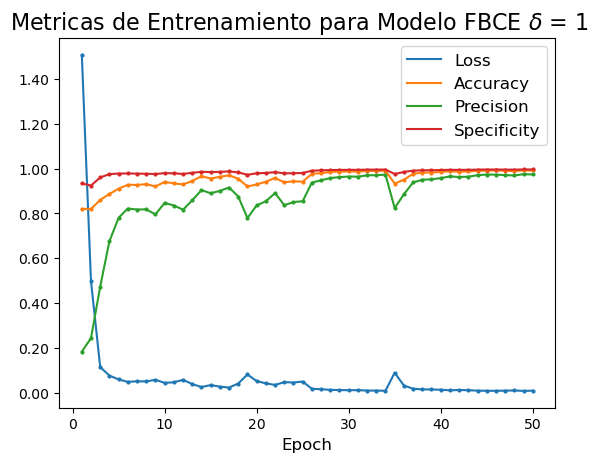

In [4]:
ylabels = ['Loss', 'Accuracy', 'Precision', 'Specificity'] # , 'Accuracy', 'Sensibilidad', 'Precisión', 'F1 Score', 'Especificidad', 'Hamming'
headers = ['loss', 'predicted_final_Accuracy', 'predicted_final_Precision', 'predicted_final_Specificity'] # , 'accuracy', 'recall_m', 'precision_m', 'f1_score_m', 'specificity_m', 'hamming_loss_m'

key = f'historialFBCE_delta_1'

entrenamiento, ax = plt.subplots(1,1)
entrenamiento.suptitle(fr'Metricas de Entrenamiento para Modelo FBCE $\delta$ = 1', y=0.94,fontsize=16)

ax.set_xlabel('Epoch', fontsize=12)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

for k in range(0,4):
    
    y = historiales_delta[key][headers[k]]
    x = np.arange(1, len(y)+1)
    
    ax.plot(x, y, label=f'{ylabels[k]}')
    ax.scatter(x, y, s=4)

ax.legend(loc='best', fontsize=12)

entrenamiento.savefig(f'../Modelo V2 Reverse FBCE/Gráficas Resultados/entrenamientoFBCE_delta1.png', dpi=300, bbox_inches='tight')  

#### 3. **Resultados Métricas de Evaluación por Tablero:**

In [5]:
test = pd.read_excel((datos[0]), sheet_name = 'test', header = 0)
stops = [f'stop.{i}' for i in range(1,401)]
stops2 = [f'stop.{i}' for i in range(0,400)]

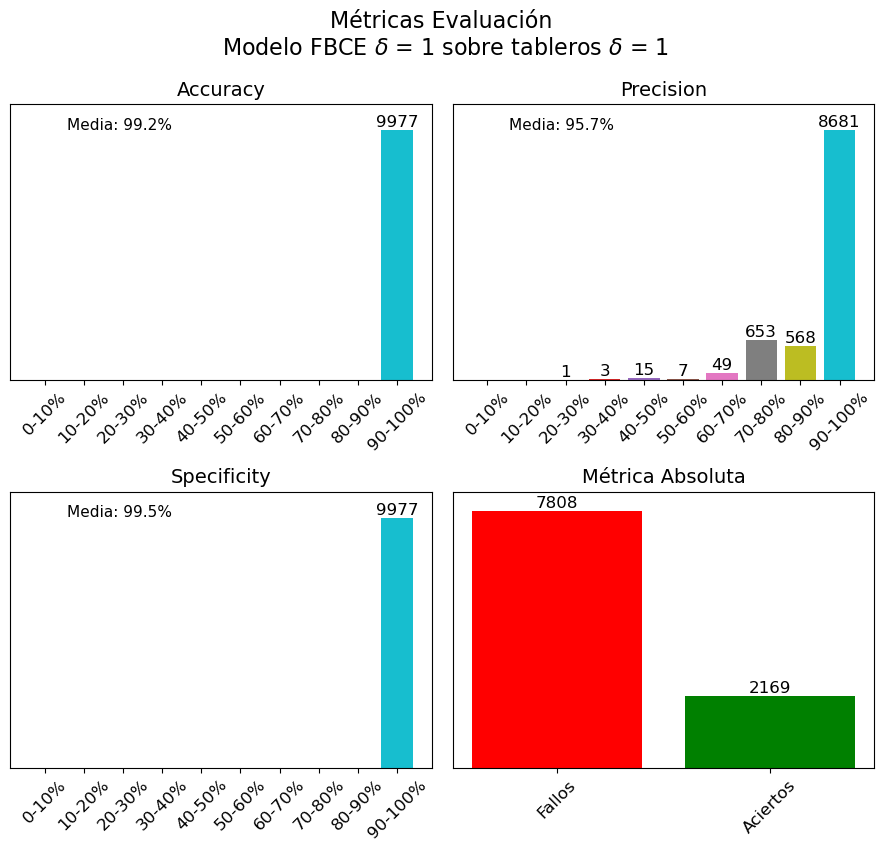

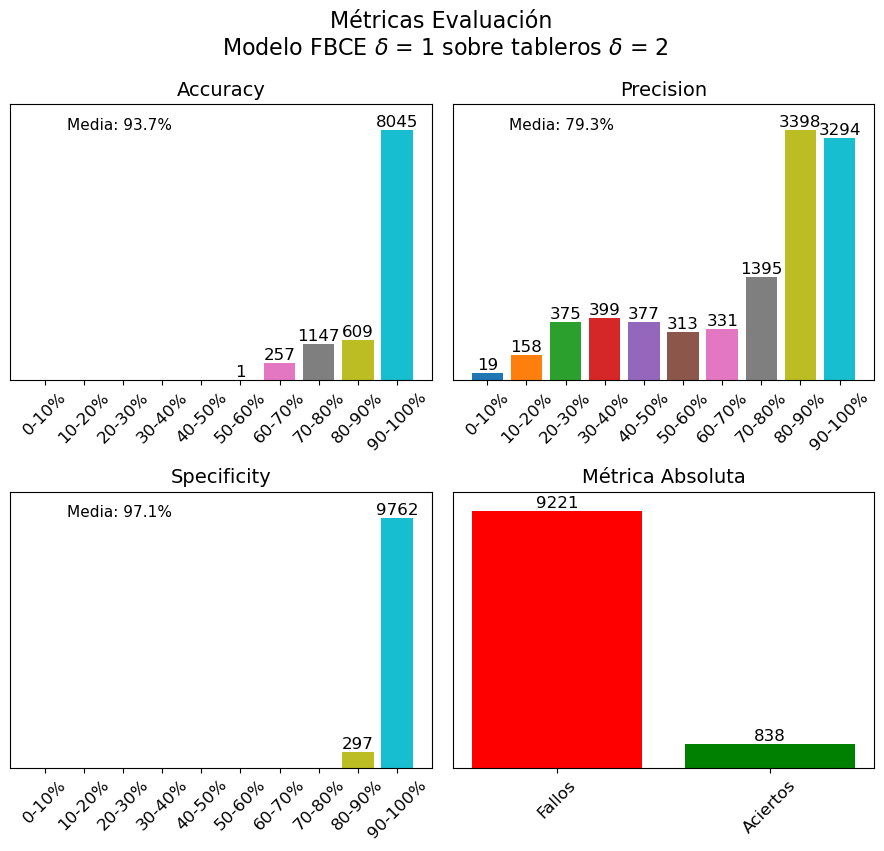

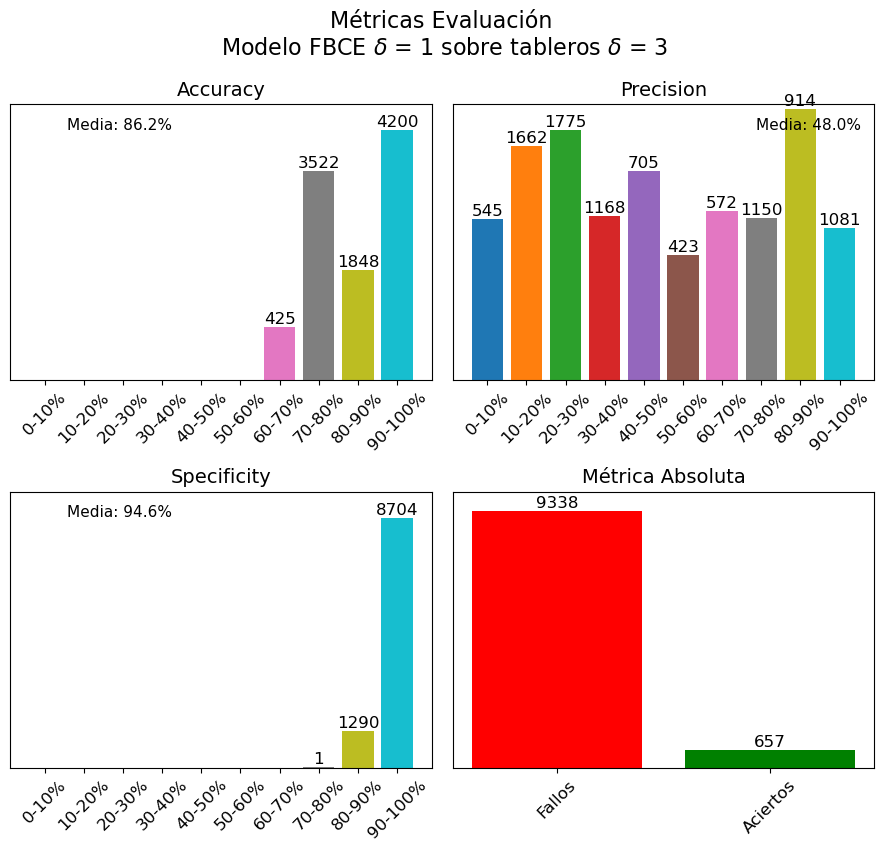

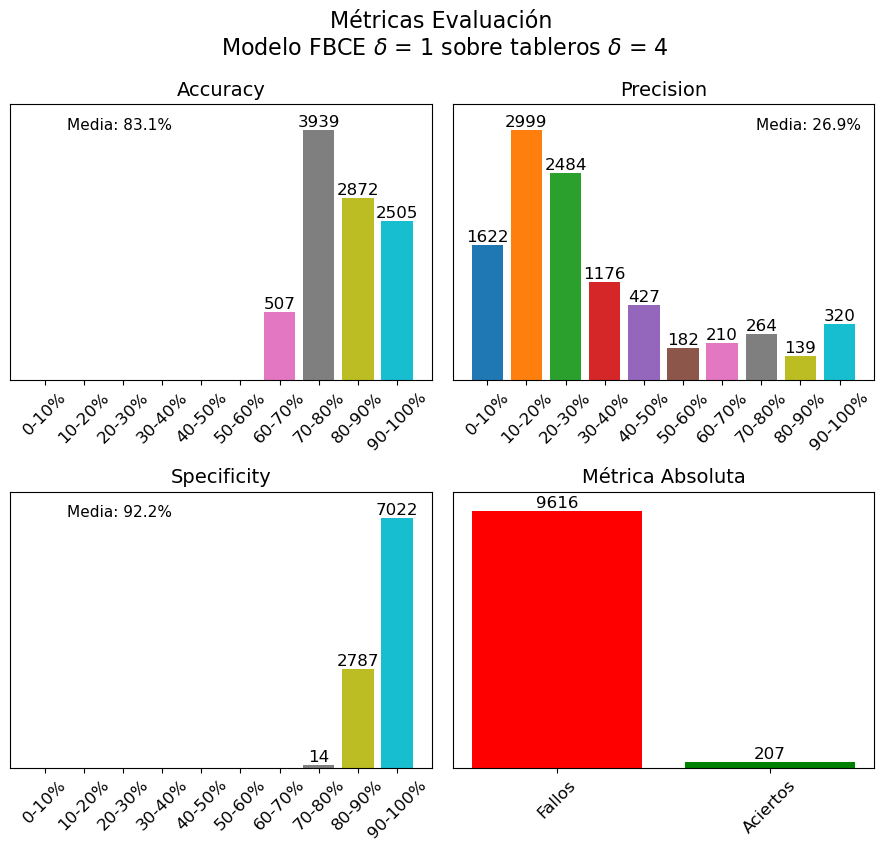

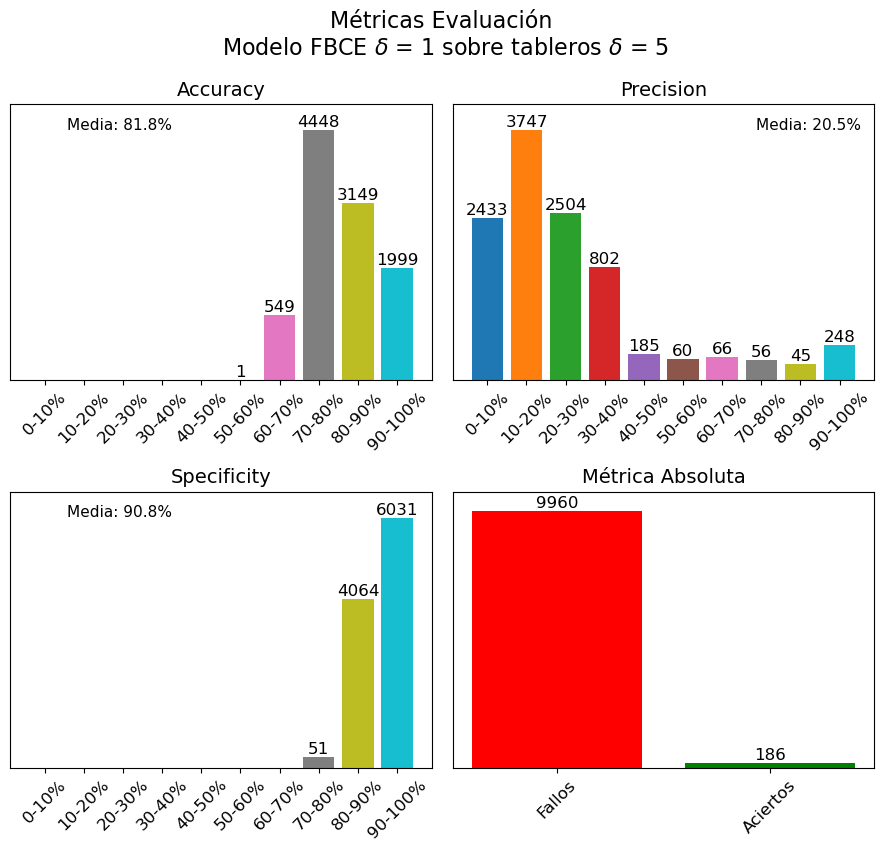

In [6]:
for delta in range(1,6):

    key = f'delta_{delta}'

    df_predicciones = pd.read_excel('prediccionesFBCE.xlsx', sheet_name=key, header=0, usecols=stops2)
    numpy_pred = df_predicciones.to_numpy() # shape (n_tableros, 400)
    tableros_finales_pred = numpy_pred.reshape(-1,20,20) # shape (n_tableros, 20, 20)
    
    delta_i = test[test['delta'] == delta]
    finales_i = np.reshape(delta_i[stops].values, (-1,20,20), order='F')  # shape (n_tableros_finales, 20,20)
    
    ### Métricas ###
    accuracies = []
    precisiones = []
    especificidades = []
    absolutos = []

    for tablero_final_pred, final_real in zip(tableros_finales_pred, finales_i):  # (20x20), (20x20)

        # Hay que usar ravel porque los comandos de las métricas esperan valores, no arrays
        y_pred = tablero_final_pred.astype(int).ravel()  # (20x20) => (400,)
        y_true = final_real.astype(int).ravel()  # (20x20) => (400,)

        # Convertir a tensores float32
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        
        # Calcular métricas
        accuracies.append(Accuracy(y_true, y_pred).numpy())
        precisiones.append(Precision(y_true, y_pred).numpy())
        especificidades.append(Specificity(y_true, y_pred).numpy())
        absolutos.append(np.array_equal(y_pred, y_true))


    ### Gráficas puntos ###
    
    id = np.arange(0, len(tableros_finales_pred)) # id de los tableros
    
    fallos = absolutos.count(0)
    aciertos = absolutos.count(1)

    lista = [accuracies, precisiones, especificidades, absolutos]
    metricas = ['Accuracy','Precision',  'Specificity', 'Absoluto']

    xlab = ['Fallos', 'Aciertos']
    barras_conteo = [fallos, aciertos]
    color_conteo = ['red', 'green']

    # --------------------- GRÁFICO BARRAS ---------------------

    fig, ax = plt.subplots(2, 2, figsize=(9,9))
    ax = ax.flatten()

    x = ['0-10%', '10-20%', '20-30%', '30-40%','40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

    for k in range(len(metricas)):

        
        contados_x_intervalos = []

        if k != len(metricas) - 1:
            ax[k].hlines(np.mean(lista[k])*100, 0,0)
            custom_legend = [Line2D([], [], linestyle='None', marker='', label=f'Media: {np.round(np.mean(lista[k])*100,1)}%')]
            # Agregar la leyenda solo con texto
            ax[k].legend(handles=custom_legend, loc='best', frameon=False, fontsize=11)

            for i in np.arange(0, 1, 0.1):
                x1 = i
                x2 = i + 0.1
                if i == 0.0:
                    contados_x_intervalos.append(np.sum((lista[k] >= x1) & (lista[k] <= x2)))
                else:
                    contados_x_intervalos.append(np.sum((lista[k] > x1) & (lista[k] <= x2)))

            
                    ### Gráficos de Barras ###

            colores = ['#1f77b4',  # azul
                        '#ff7f0e',  # naranja
                        '#2ca02c',  # verde
                        '#d62728',  # rojo
                        '#9467bd',  # morado
                        '#8c564b',  # marrón
                        '#e377c2',  # rosa
                        '#7f7f7f',  # gris
                        '#bcbd22',  # verde amarillento
                        '#17becf']  # azul verdoso
            
            
            for j in range(0, len(contados_x_intervalos)):
                
                real = contados_x_intervalos[j]
                y = real/len(id)
                
                if real< 1000:
                    if real == 0:

                        ax[k].bar(x[j], y, color='black')

                    elif real < 100:

                        ax[k].bar(x[j], y*5,color = colores[j])
                        ax[k].annotate(f'{contados_x_intervalos[j]}', xy=(x[j], y*5), ha='center', va='bottom', fontsize=12, color='black')
                        
                        
                    else:
                        ax[k].bar(x[j], y*2,color = colores[j])
                        ax[k].annotate(f'{contados_x_intervalos[j]}', xy=(x[j], y*2), ha='center', va='bottom', fontsize=12, color='black')
                        
                else:
                    
                    ax[k].bar(x[j],y*0.95, color = colores[j])
                    ax[k].annotate(f'{contados_x_intervalos[j]}', xy=(x[j], y*0.95), ha='center', va='bottom', fontsize=12, color='black')
                    

            ax[k].set_yticks([])
            ax[k].set_ylim(0, (max(contados_x_intervalos))/len(id)*1.05)
            ax[k].set_title(f'{metricas[k]}', fontsize=14)
            ax[k].tick_params(axis='x', rotation=45, labelsize=12) 

        else:
            for i in range(2):
                ax[k].bar(x = xlab[i], height = barras_conteo[i], color= color_conteo[i])
                ax[k].annotate(f'{barras_conteo[i]}', xy=(xlab[i], barras_conteo[i]), ha='center', va='bottom', fontsize=12, color='black')
                ax[k].tick_params(axis='x', rotation=45, labelsize=12)  
            ax[k].set_title('Métrica Absoluta', fontsize=14)
            ax[k].set_yticks([])
            ax[k].set_ylim(0, max(barras_conteo)*1.075)

    fig.suptitle('Métricas Evaluación \n' fr'Modelo FBCE $\delta$ = 1 sobre tableros $\delta$ = {delta}', y = 0.94, fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig(f'../Modelo V2 Reverse FBCE/Gráficas Resultados/barrasFBCE_delta{delta}.png', dpi=300, bbox_inches='tight')
    
plt.show()

    # --------------------- GRÁFICO DISPERSIÓN ---------------------
    # fig, ax = plt.subplots(2, 3, figsize=(10,10))
    # ax = ax.flatten()

    # for k in range(len(metricas)):

    #     if k != len(metricas) - 1:
    #         ax[k].scatter(id, lista[k], s=1, color ='blue')  
    #         # ax[k].scatter(pos, [lista[k][i] for i in pos_list], s=20, color='red', label='Tableros seleccionados')
    #         # print(f'Posiciones:{pos}', f'Valores: {[lista[k][i] for i in pos_list]}')
    #         # ax[k].set_yticks([lista[k][i] for i in pos_list])
    #         ax[k].set_ylim(0,1.05)
    #         ax[k].set_title(f'{metricas[k]} por tablero') 
    #         ax[k].set_ylabel(metricas[k])
    #         ax[k].hlines(np.mean(lista[k]), 0, id[-1], color='red', linewidth=4, label = f'Media: {np.mean(lista[k]):.2f}')
    #         ax[k].legend(loc='best')
    #     else:
    #         for i in range(2):
    #             ax[k].bar(x = xlab[i], height = barras_conteo[i], color= color_conteo[i])
    #             ax[k].annotate(f'{barras_conteo[i]}', xy=(xlab[i], barras_conteo[i]), ha='center', va='bottom', fontsize=8, color='black')

    #         ax[k].set_title('Predicciones completamente correctas')
    #         ax[k].set_yticks([])
    #         ax[k].set_ylim(0, max(barras_conteo)*1.075)
    
    # fig.suptitle(fr'Métricas Evaluación Modelo $\delta$ = {delta}', y = 0.94)
    # fig.supxlabel('Id Tablero', y=0.05)
    # fig.savefig(f'../Modelo V2 Reverse FBCE/Gráficas Resultados/distribucionFBCE_delta{delta}.png', dpi=300, bbox_inches='tight')
    


#### 4. **Comparativa:**

----------------------------------------------------------------------------------------


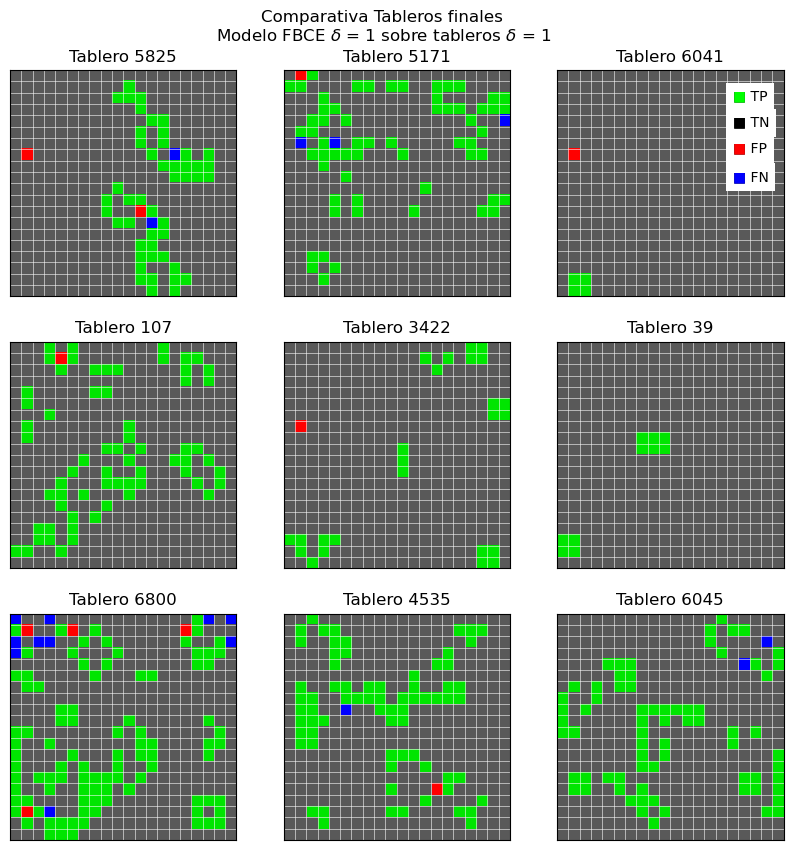

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001E26BA2BA60>>
Traceback (most recent call last):
  File "c:\Users\afdez\miniconda3\envs\tfg_3.9\lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
KeyboardInterrupt: 


----------------------------------------------------------------------------------------


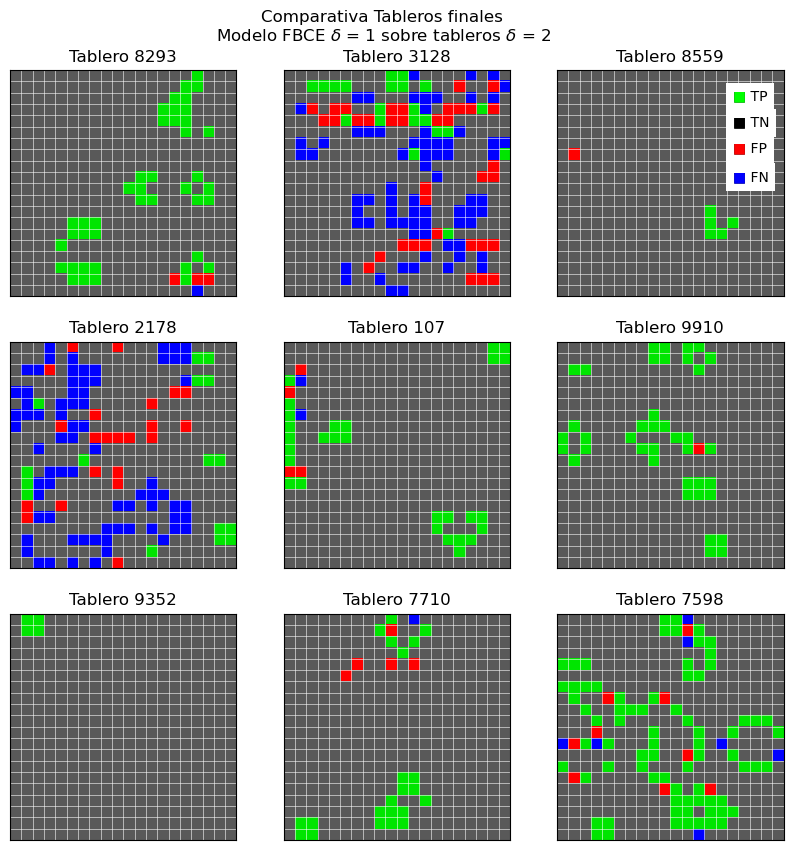

----------------------------------------------------------------------------------------


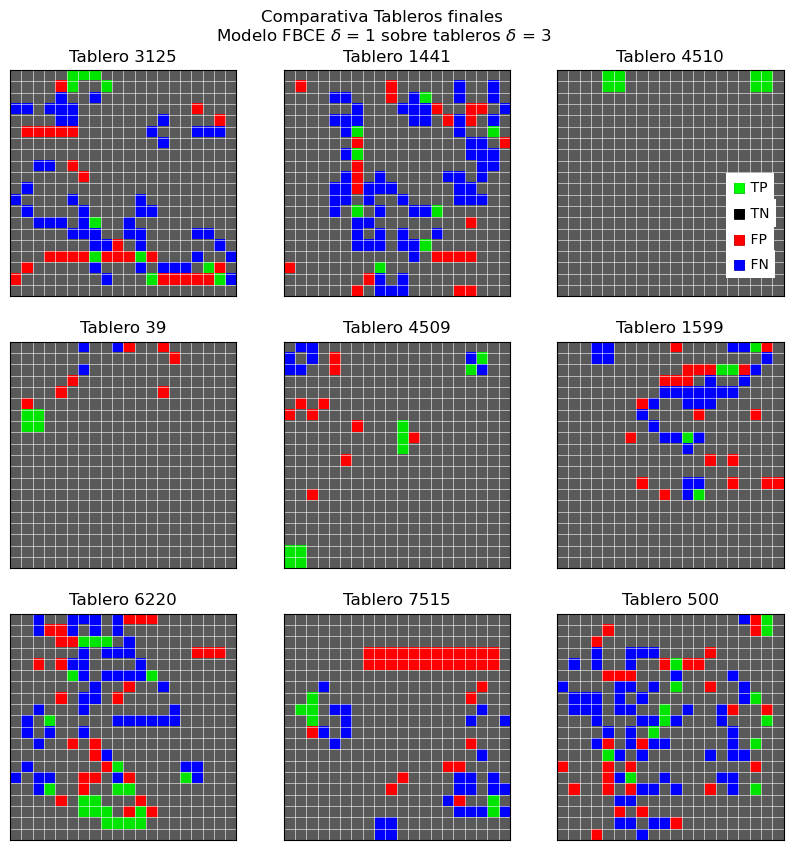

In [ ]:
stops2 = [f'stop.{i}' for i in range(0,400)]
for delta in range(1,6):

    key = f'delta_{delta}'

    # Leer todo el sheet del delta
    df_predicciones = pd.read_excel('prediccionesFBCE.xlsx', sheet_name=key, header=0, usecols=stops2)

    # Filtro los datos del test asociados a esta delta:
    delta_i = test[test['delta'] == delta]

    # Definir índices aleatorios comunes
    n_filas = len(delta_i)
    indices_aleatorios = np.random.RandomState(seed=42).choice(n_filas, size=9, replace=False)

    # Seleccionar filas específicas
    df_muestra = df_predicciones.iloc[indices_aleatorios]
    delta_muestra = delta_i.iloc[indices_aleatorios]

    # Pasar a NumPy
    numpy_pred = df_muestra.to_numpy()  # shape (10, 400)
    tableros_finales_pred = numpy_pred.reshape(-1, 20, 20)  # shape (10, 20, 20)

    finales_i = np.reshape(delta_muestra[stops].values, (-1, 20, 20, 1), order='F')

    fig, axes = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle('Comparativa Tableros finales \n' fr'Modelo FBCE $\delta$ = 1 sobre tableros $\delta$ = {delta}', y = 0.94)
    axes = axes.flatten()

    if delta in {1,2,4,5}:
       axes[2].text(15, 2.2, '\u25A0 TP', color='black', fontsize=10, bbox={'facecolor': 'white', 'pad': 5,'edgecolor': 'none'})
       axes[2].text(15, 2.2, '\u25A0', color='lime', fontsize=10) 

       axes[2].text(15, 4.5, '\u25A0 TN', color='black', fontsize=10,
             bbox={'facecolor': 'white', 'pad': 5,'edgecolor': 'none'}) 
       axes[2].text(15, 4.5, '\u25A0', color='black', fontsize=10)
    
       axes[2].text(15, 6.8, '\u25A0 FP', color='black', fontsize=10,
             bbox={'facecolor': 'white', 'pad': 5,'edgecolor': 'none'})
       axes[2].text(15, 6.8, '\u25A0', color='red', fontsize=10)
   
       axes[2].text(15, 9.3, '\u25A0 FN', color='black', fontsize=10,
             bbox={'facecolor': 'white', 'pad': 5,'edgecolor': 'none'})
       axes[2].text(15, 9.3, '\u25A0', color='blue', fontsize=10)
    else:
       axes[2].text(15, 10.2, '\u25A0 TP', color='black', fontsize=10, bbox={'facecolor': 'white', 'pad': 5,'edgecolor': 'none'})
       axes[2].text(15, 10.2, '\u25A0', color='lime', fontsize=10) 

       axes[2].text(15, 12.5, '\u25A0 TN', color='black', fontsize=10,
             bbox={'facecolor': 'white', 'pad': 5,'edgecolor': 'none'}) 
       axes[2].text(15, 12.5, '\u25A0', color='black', fontsize=10)
    
       axes[2].text(15, 14.8, '\u25A0 FP', color='black', fontsize=10,
             bbox={'facecolor': 'white', 'pad': 5,'edgecolor': 'none'})
       axes[2].text(15, 14.8, '\u25A0', color='red', fontsize=10)
   
       axes[2].text(15, 17, '\u25A0 FN', color='black', fontsize=10,
             bbox={'facecolor': 'white', 'pad': 5,'edgecolor': 'none'})
       axes[2].text(15, 17, '\u25A0', color='blue', fontsize=10)

    i = 0
    for final, y_real in zip(tableros_finales_pred, finales_i):
         y_real = y_real.reshape(20,20)
         y_pred = final.reshape(20,20)

         comparativa = np.zeros((20,20,3))
        # Criterio de colores:
     
         comparativa[(y_real == 1) & (y_pred == 1)] = [0,0.9,0] # Si coinciden, verde (TP)
         comparativa[(y_real == 0) & (y_pred == 0)] = (0.35, 0.35, 0.35)  # Si coinciden, negro (TN)
         comparativa[(y_real == 0) & (y_pred == 1)] = [1,0,0]  # Muerto pero vivo, rojo (FP)
         comparativa[(y_real == 1) & (y_pred == 0)] = [0,0,1]# Vivo pero muerto, azul (FN)
         axes[i].imshow(comparativa)
         axes[i].set_xticks([])
         axes[i].set_yticks([])
         axes[i].set_title(f'Tablero {indices_aleatorios[i]}')

         # Añadir mallado
         axes[i].set_xticks(np.arange(-0.5, 20, 1), minor=True)
         axes[i].set_yticks(np.arange(-0.5, 20, 1), minor=True)
         axes[i].grid(which='minor', color='white', linestyle='-', linewidth=0.4)

         # Eliminar totalmente las etiquetas de los ticks (sin numeritos, sin marcas)
         axes[i].tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
          # Quitar los ticks mayores y menores (solo deja la grid)
         axes[i].set_xticks([])
         axes[i].set_yticks([])

         i +=1

    print('----------------------------------------------------------------------------------------')
    
    plt.show()